# K-means Image Clustering

### K-means clustering with Lloyd's algorithm
Given a dataset $x_1, \dotsc, x_n \in \mathbb{R}^d$ and an integer $1 \le k \le n$, the k-means objective function is given by $$\min_{\pi_1,\dotsc,\pi_k} \sum i=1 \sum j\in\pi_i ‖ x_j − \mu_i‖_2^2 ,\;\;\;\;\; \mu_i = \frac{1}{|\pi_i|} \sum_{j\in\pi_i} x_j$$ Above, $\{\pi_i\}_{i=1}^k$ is a partition of $\{1, 2, ..., n\}$. The objective is NP-hard to find a global minimizer of.
Nevertheless, Lloyd’s algorithm typically works well in practice.

Once we have Lloyd's algorithm running it is executed on the MNIST handwritten digits dataset. We train it on the 60000 images and print out the 10 clusters it identifies. We see that it does an okay job of identifing unique digits however it does not do a perfect job. It seems 4s and 9s, 5s and 8s, 1s and 7s are difficult to distinguish.

In [90]:
from typing import List, Tuple

import numpy as np

from utils import problem


def calculate_centers(
    data: np.ndarray, classifications: np.ndarray, num_centers: int
) -> np.ndarray:
    """
    Sub-routine of Lloyd's algorithm that calculates the centers given datapoints and their respective classifications/assignments.
    num_centers is additionally provided for speed-up purposes.

    Args:
        data (np.ndarray): Array of shape (n, d). Training data set.
        classifications (np.ndarray): Array of shape (n,) full of integers in range {0, 1, ...,  num_centers - 1}.
            Data point at index i is assigned to classifications[i].
        num_centers (int): Number of centers for reference.
            Might be usefull for pre-allocating numpy array (Faster that appending to list).

    """
    d = data.shape[1] #grab d
    centers = np.zeros((num_centers, d)) #initialize empry matrix
    
    for label in range(num_centers): #iterate over classification labels.
        indicies = np.where(classifications == label)[0] #get the indices for classification labels
        data_label = data[indicies] #New dataset where all labels are the same.
        centers[label] = np.mean(data_label, axis = 0) #calculate the mean across the rows. (e.g sum rows 1-n for each column)
        
    return centers #shape (num_centers, d)


def cluster_data(data: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Sub-routine of Lloyd's algorithm that clusters datapoints to centers given datapoints and centers.

    Args:
        data (np.ndarray): Array of shape (n, d). Training data set.
        centers (np.ndarray): Array of shape (k, d). Each row is a center to which a datapoint can be clustered.

    Returns:
        np.ndarray: Array of integers of shape (n,), with each entry being in range {0, 1, 2, ..., k - 1}.
            Entry j at index i should mean that j^th center is the closest to data[i] datapoint.
    """
    n,d = data.shape
    k,d = centers.shape
    
    distances = np.empty((n,k))
    
    for i in range(k):
        center = centers[i]
        distances[:, i] = np.linalg.norm(data - center, axis=1)
    
    cluster_assignment = distances.argmin(axis=1)
    return cluster_assignment


def calculate_error(data: np.ndarray, centers: np.ndarray) -> float:
    """Calculates error/objective function on a provided dataset, with trained centers.

    Args:
        data (np.ndarray): Array of shape (n, d). Dataset to evaluate centers on.
        centers (np.ndarray): Array of shape (k, d). Each row is a center to which a datapoint can be clustered.
            These should be trained on training dataset.

    Returns:
        float: Single value representing mean objective function of centers on a provided dataset.
    """
    distances = np.zeros((data.shape[0], centers.shape[0]))
    for idx, center in enumerate(centers):
        distances[:, idx] = np.sqrt(np.sum((data - center) ** 2, axis=1))
    return np.mean(np.min(distances, axis=1))


def lloyd_algorithm(
    data: np.ndarray, num_centers: int, epsilon: float = 10e-4
) -> Tuple[np.ndarray, List[float]]:
    """Main part of Lloyd's Algorithm.

    Args:
        data (np.ndarray): Array of shape (n, d). Training data set.
        num_centers (int): Number of centers to train/cluster around.
        epsilon (float, optional): Epsilon for stopping condition.
            Training should stop when max(abs(centers - previous_centers)) is smaller or equal to epsilon.
            Defaults to 10e-3.

    Returns:
        np.ndarray: Tuple of 2 numpy arrays:
            Element at index 0: Array of shape (num_centers, d) containing trained centers.
            Element at index 1: List of floats of length # of iterations
                containing errors at the end of each iteration of lloyd's algorithm.

    """
    #initialize centers on just first data points. Better to use Kmeans ++ initilization
    init_centers = data[:num_centers,:]
    centers = init_centers
    
    #store error here
    errors = np.empty(200)
    #initialize stop value
    delta = 100
    
    i = 0
    while (delta > epsilon):
        #assign clusters:
        cluster_assignment = cluster_data(data, centers)
        #calculate the centers:
        prev_centers = centers
        centers = calculate_centers(data, cluster_assignment, num_centers)
        #calculate the error of new centers
        error = calculate_error(data, centers)
        errors[i] = error
        delta = np.max(np.abs(centers - prev_centers))
        i += 1
        if i > 200:
            break
    
    return((centers,errors[:i]))
    


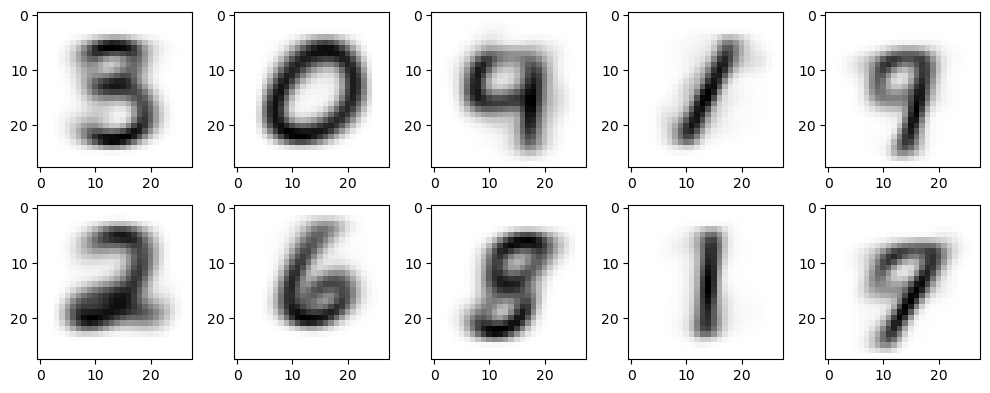

In [89]:
#if __name__ == "__main__":
    #from k_means import calculate_error, lloyd_algorithm  # type: ignore
#else:
   # from .k_means import lloyd_algorithm, calculate_error

import matplotlib.pyplot as plt
import numpy as np

from utils import load_dataset, problem

def main():
    """Main function of k-means problem

    Run Lloyd's Algorithm for k=10, and report 10 centers returned.

    """
    (x_train, _), (x_test, _) = load_dataset("mnist")
    
    k_centers = lloyd_algorithm(x_train, num_centers = 10)
    return(k_centers)

if __name__ == "__main__":
    k_centers = main()
    plt.figure(figsize = (10,4))

    for idx, image in enumerate(k_centers[0]):
        np_image = image.reshape(28,28)
        plt.subplot(2,5,idx+1)
        plt.imshow(np_image, cmap = 'gray_r')

    plt.tight_layout()
    plt.show()
        


# Conclusions
Fun model, was very interesting to see that it essentially can spit out most of the digits between 0-9 correctly. Super neat that it is unsupervised.